# Deepguard classifier

This notebook contains the process for training a classifier to obtain more accurate results for predicting transformer failures

## Importing libraries

In [10]:
import pandas as pd
import os
import csv
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import pickle

## Gathering data
The DGA dataset is the bigger we have, thus I will use only this one for the demonstration

In [11]:
base_raw_data_path = "../raw_data"
df_dga = pd.read_excel(os.path.join(base_raw_data_path, "DGA dataset.xlsx"))

In [16]:
df_dga

,NM,H2,CH4,C2H6,C2H4,C2H2,Type,class
0,1,3930.0,2397.0,157.0,0.0,0.0,Partial discharge,PD - Partial Discharges
1,2,37800.0,1740.0,249.0,8.0,8.0,Partial discharge,PD - Partial Discharges
2,3,92600.0,10200.0,0.0,0.0,0.0,Partial discharge,PD - Partial Discharges
3,4,8266.0,1061.0,22.0,0.0,0.0,Partial discharge,PD - Partial Discharges
4,5,9340.0,995.0,60.0,6.0,7.0,Partial discharge,PD - Partial Discharges
...,...,...,...,...,...,...,...,...
196,197,24700.0,61000.0,26300.0,42100.0,1560.0,Low/Middle-temperature overheating,T1 and T2 - Thermal Faults < 700 °C
197,198,14.0,44.0,124.0,7.0,1.0,Low/Middle-temperature overheating,T1 and T2 - Thermal Faults < 700 °C
198,199,2031.0,149.0,20.0,3.0,0.0,Low/Middle-temperature overheating,T1 and T2 - Thermal Faults < 700 °C
199,200,480.0,1075.0,298.0,1132.0,0.0,Low/Middle-temperature overheating,T1 and T2 - Thermal Faults < 700 °C


## Uniforming data
Here we map the fault type in the standard duval naming convention

In [13]:
dga2duval = {
 "Spark discharge": 'D1 - Discharges of Low Energy',
 "Arc discharge": 'D2 - Discharges of High Energy',
 "N": 'Normal',
 "Partial discharge": 'PD - Partial Discharges',
 "Low-temperature overheating": 'T1 and T2 - Thermal Faults < 700 °C',
 "Middle-temperature overheating": 'T1 and T2 - Thermal Faults < 700 °C',
 "Low/Middle-temperature overheating": 'T1 and T2 - Thermal Faults < 700 °C',
 "High-temperature overheating": 'T3 - Thermal Faults > 700 °C '
}

df_dga['class'] = [dga2duval[x] for x in df_dga['Type']]

<Axes: xlabel='class'>

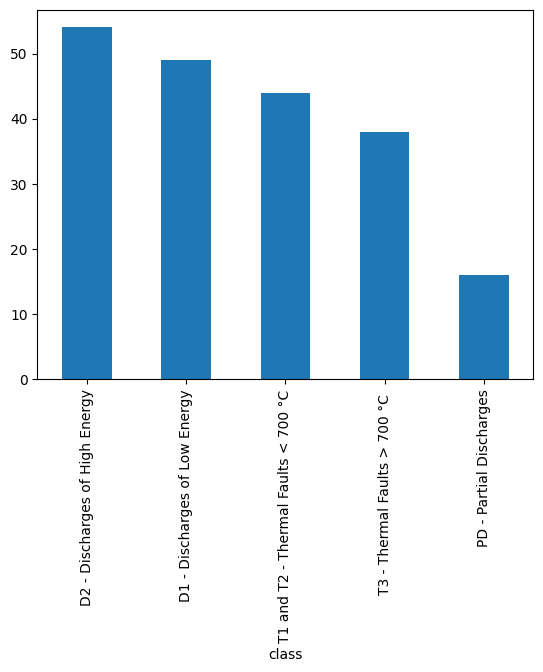

In [15]:
df_dga['class'].value_counts().plot.bar()

Checking for null values. Here we can see there aren't so we can go on skipping the filling process

In [18]:
df_dga.isna().sum()

NM       0
H2       0
CH4      0
C2H6     0
C2H4     0
C2H2     0
Type     0
class    0
dtype: int64

## Labeling
Here we convert our string in integer values, so the model can process this type

In [19]:
classes = list(set(df_dga['class'].tolist()))
print(classes)
le = LabelEncoder()
le.fit(classes)
print(le.transform(classes))
# Running this command: le.inverse_transform([0, 1])
# we can get back the info from Int to String

['T1 and T2 - Thermal Faults < 700 °C', 'T3 - Thermal Faults > 700 °C ', 'PD - Partial Discharges', 'D1 - Discharges of Low Energy', 'D2 - Discharges of High Energy']
[3 4 2 0 1]
['D1 - Discharges of Low Energy' 'D2 - Discharges of High Energy']


In [20]:
selected_columns = ['H2', 'CH4', 'C2H2', 'C2H4', 'C2H6'] #, 'CO','CO2'
x_conc = df_dga[selected_columns].to_numpy()
y_conc = le.transform(df_dga['class'])
print(len(x_conc), len(y_conc))

201 201


In [21]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced" , min_samples_leaf=3, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, x_conc, y_conc, cv=10)
scores.mean()

0.701904761904762

In [ ]:
# Provare a testare il modello dandogli in pasto dei numeri

## Salvataggio modello in pickle

In [22]:
import pickle
models_path = '../models'
# save le
with open(os.path.join(models_path,'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

# save pkl
with open(os.path.join(models_path,'model.pkl'), 'wb') as f:
    pickle.dump(clf, f)

## Load model from pickle

In [ ]:
import pickle
models_path = '../models'

# load le
with open(os.path.join(models_path,'label_encoder.pkl'), 'rb') as f:
    le = pickle.load(f)

# load pkl
with open(os.path.join(models_path,'model.pkl'), 'rb') as f:
    clf = pickle.load(f)